In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess

In [2]:
# Run the data generation script
subprocess.run(["g++", "-o", "fourier", "fourier.cpp", "-lm"])
subprocess.run(["./fourier"])

CompletedProcess(args=['./fourier'], returncode=0)

In [3]:
csv_file = []
for file in os.listdir("fourier_data"):
    if file.endswith(".csv"):
        csv_file.append(file)
        print(file)


trajectory_position.csv
PID1.csv
inverted_trajectory_component.csv
alternative_kalman2.csv
luenberger2.csv
alternative_kalman1.csv
inverted_trajectory_position.csv
kalman2.csv
extended_kalman1.csv
trajectory_component.csv
kalman1.csv
PID2.csv
luenberger1.csv
extended_kalman2.csv
LQR1.csv
LQR2.csv


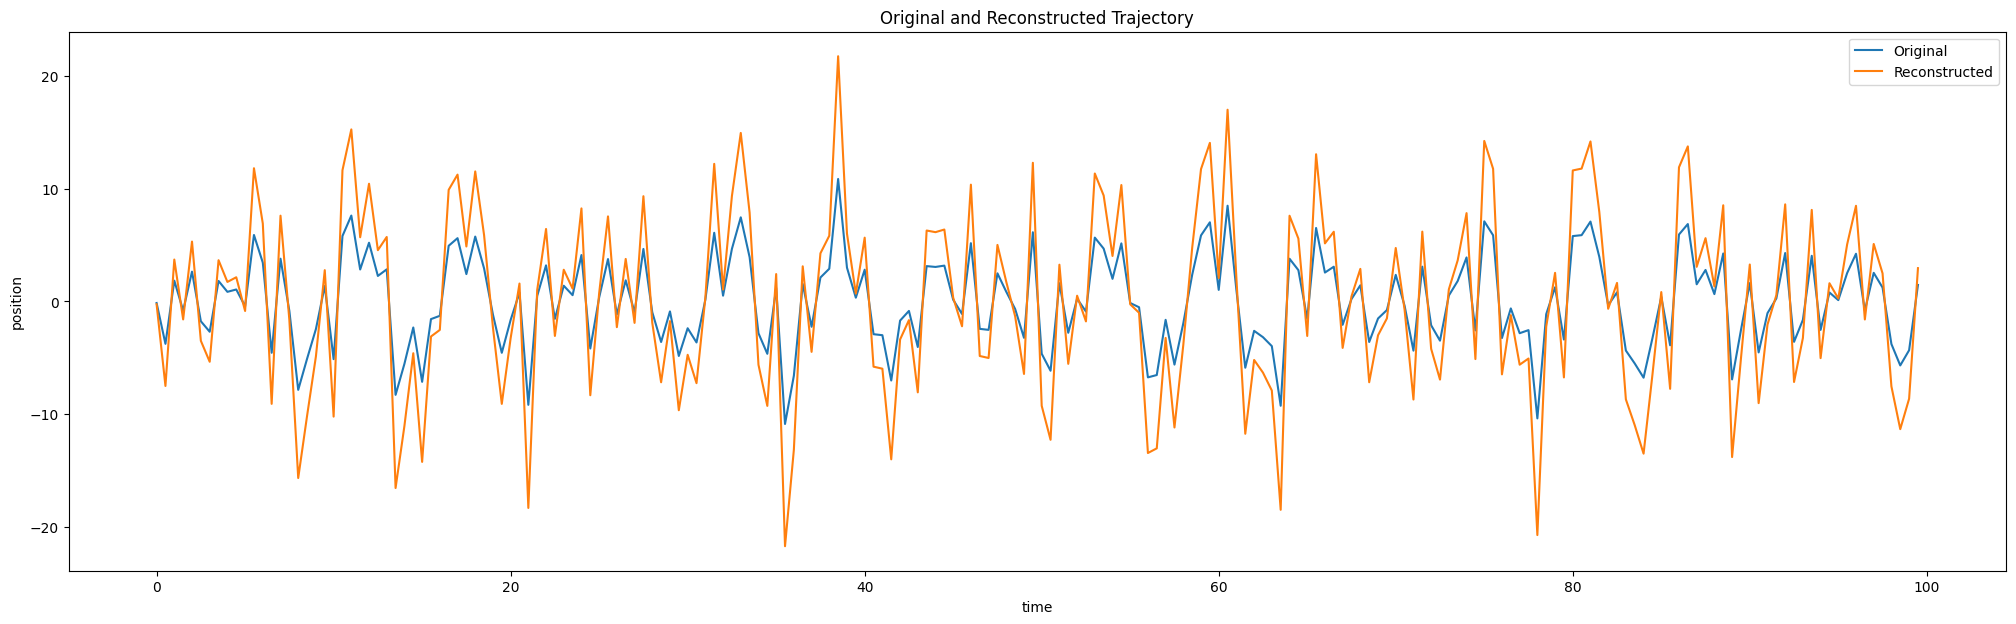

In [4]:
trajectory = pd.read_csv("fourier_data/trajectory_position.csv")
inverted_trajectory = pd.read_csv("fourier_data/inverted_trajectory_position.csv")

# plot in a figure size x=25, y=7
fig = plt.figure(figsize=(25, 7))
plt.plot(trajectory["time"], trajectory["position"])
plt.plot(inverted_trajectory["time"], inverted_trajectory["position"])
plt.xlabel("time")
plt.ylabel("position")
plt.title("Original and Reconstructed Trajectory")
plt.legend(["Original", "Reconstructed"])
plt.show()

In [5]:
# Combine trajectory and inverted trajectory dataframes with unique headers
trajectory_component = pd.read_csv("fourier_data/trajectory_component.csv")
inverted_trajectory_component = pd.read_csv("fourier_data/inverted_trajectory_component.csv")

# convert to table
trajectory_component = trajectory_component.pivot_table(index="n", values=["angular_velocity", "amplitude", "phase"])
inverted_trajectory_component = inverted_trajectory_component.pivot_table(index="n", values=["angular_velocity", "amplitude", "phase"])

trajectory_component

amplitude  angular_velocity    phase
n                                      
0   3.073270         -0.902785  3.70411
1   2.587500          9.148260  5.95487
2   2.409950          5.164250  1.40374
3   3.016260          1.179570  5.14566
4   0.319060         -8.933910  4.36546
5   0.375837         -6.282460  8.04453
6   0.370160          2.379110  2.56970
7   1.260140         -3.887440  3.69896
8   0.595683         -5.647290  4.05058
9   0.576160          4.299730  1.07621

In [6]:
inverted_trajectory_component

amplitude  angular_velocity    phase
n                                      
0   0.046104          0.000000  3.14159
1   0.093117          0.062832 -3.12795
2   0.095898          0.125664 -3.11338
3   0.100742          0.188496 -3.09696
4   0.108011          0.251327 -3.07769
5   0.118261          0.314159 -3.05492
6   0.132449          0.376991 -3.02806
7   0.152076          0.439823 -2.99644
8   0.179717          0.502655 -2.95961
9   0.220002          0.565487 -2.91695

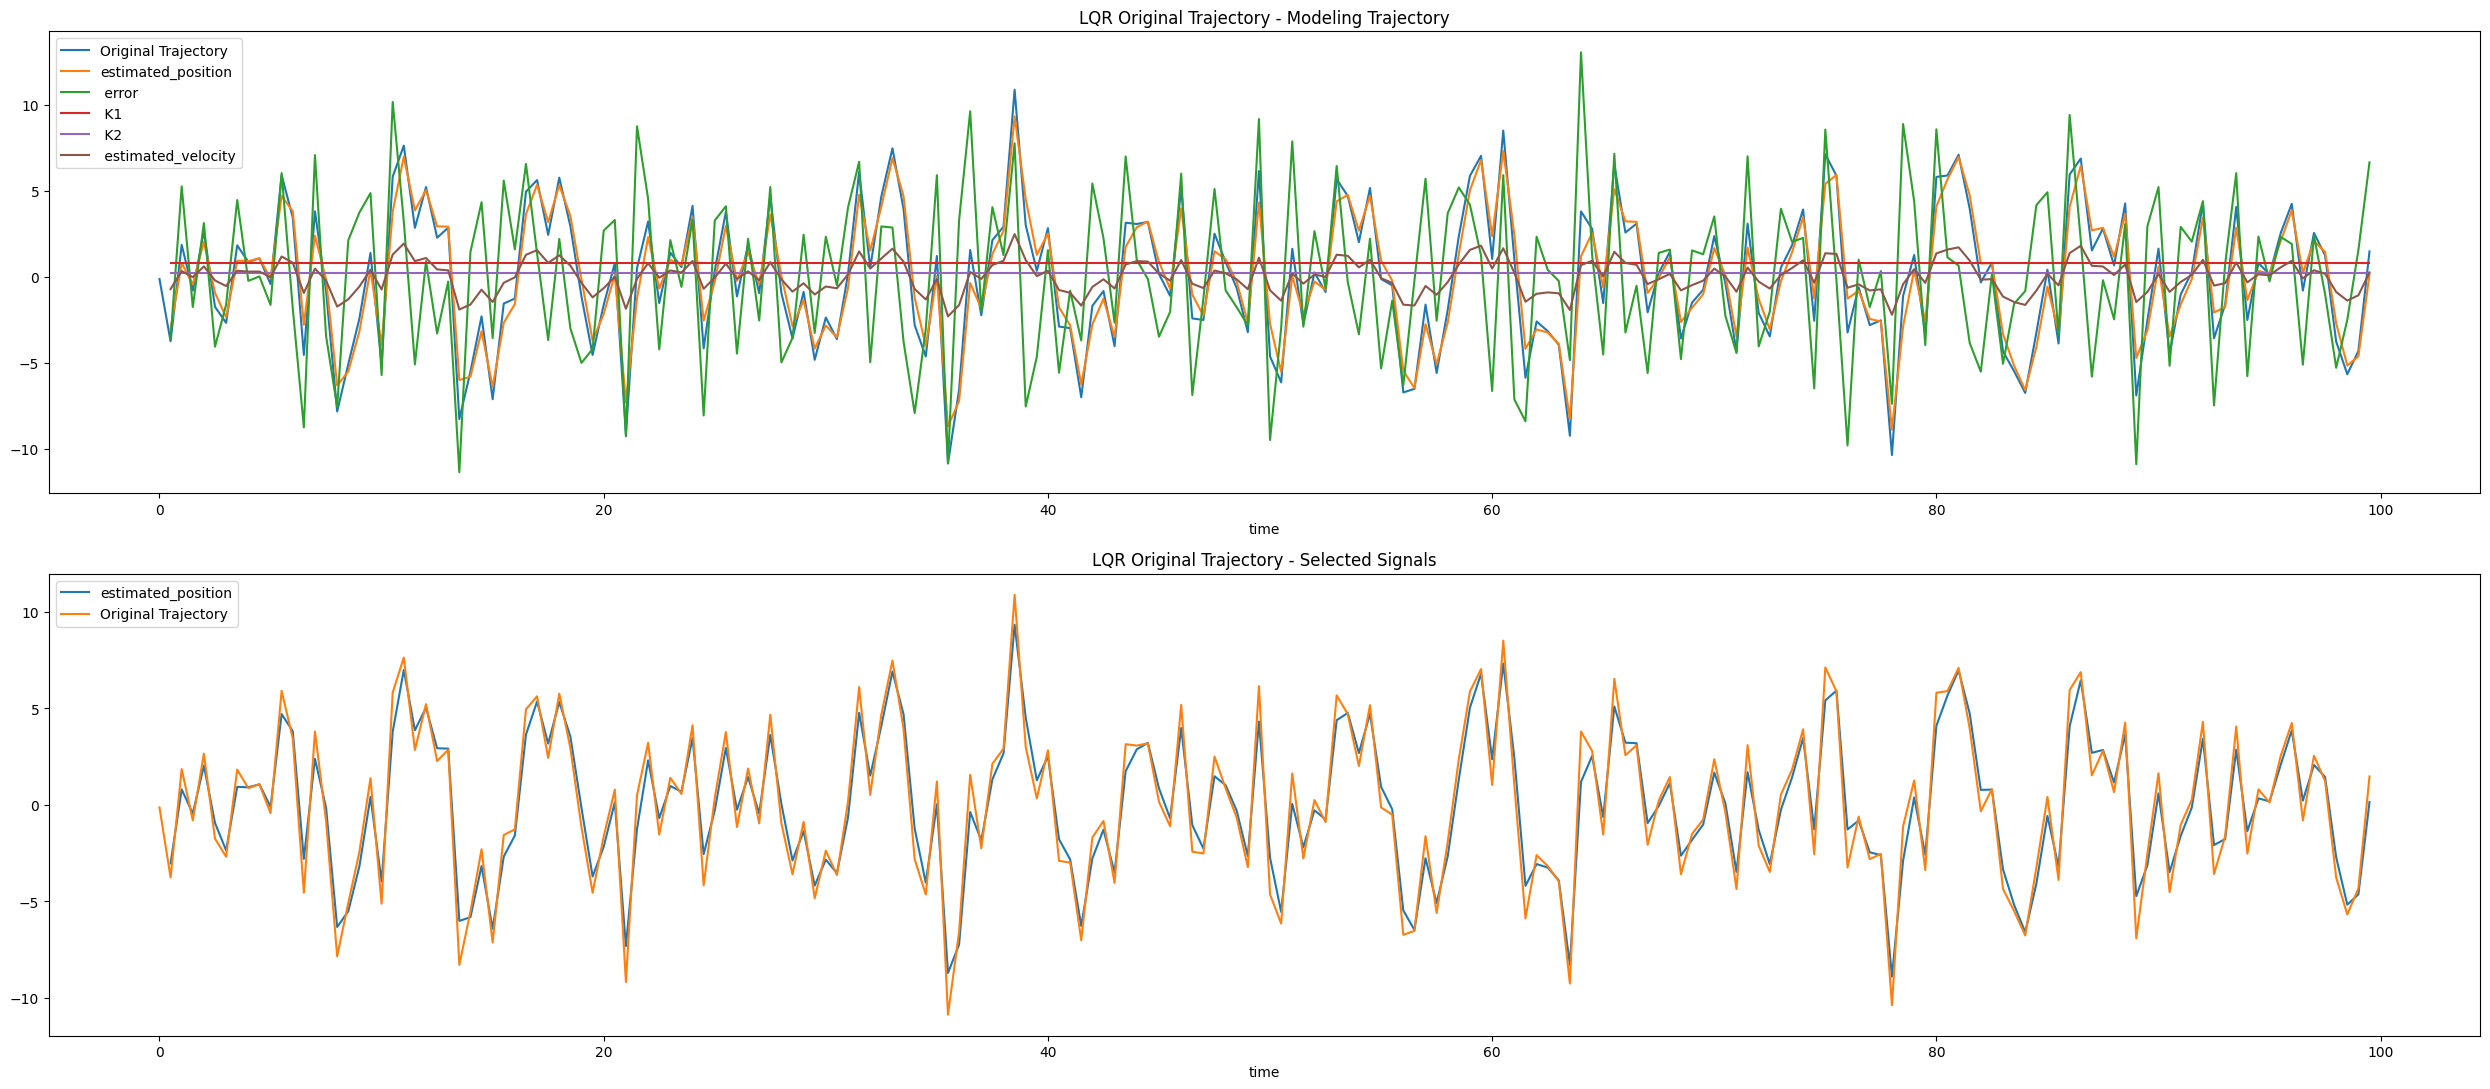

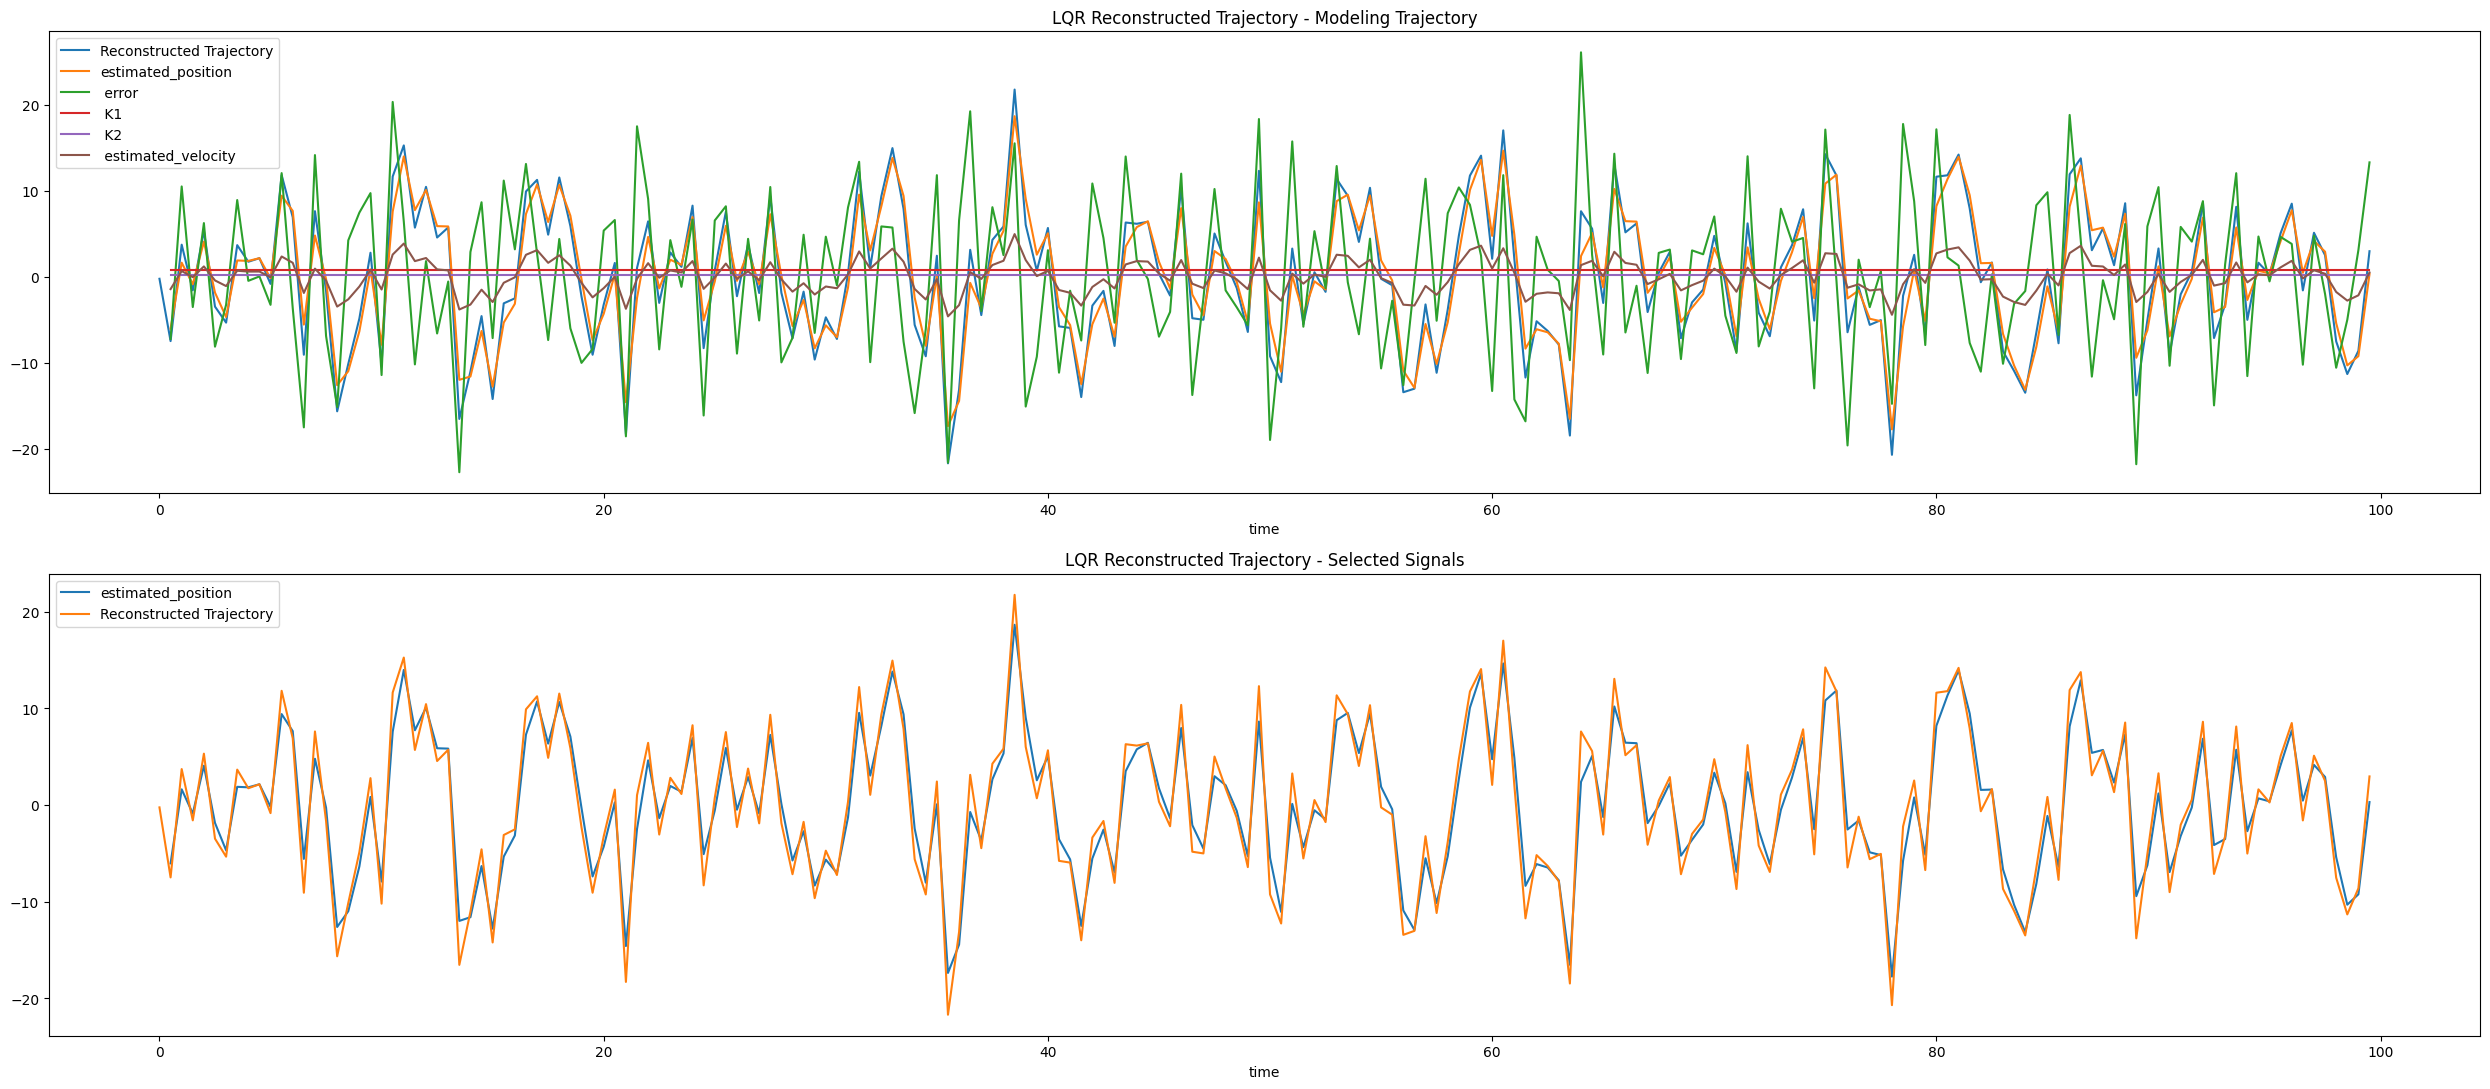

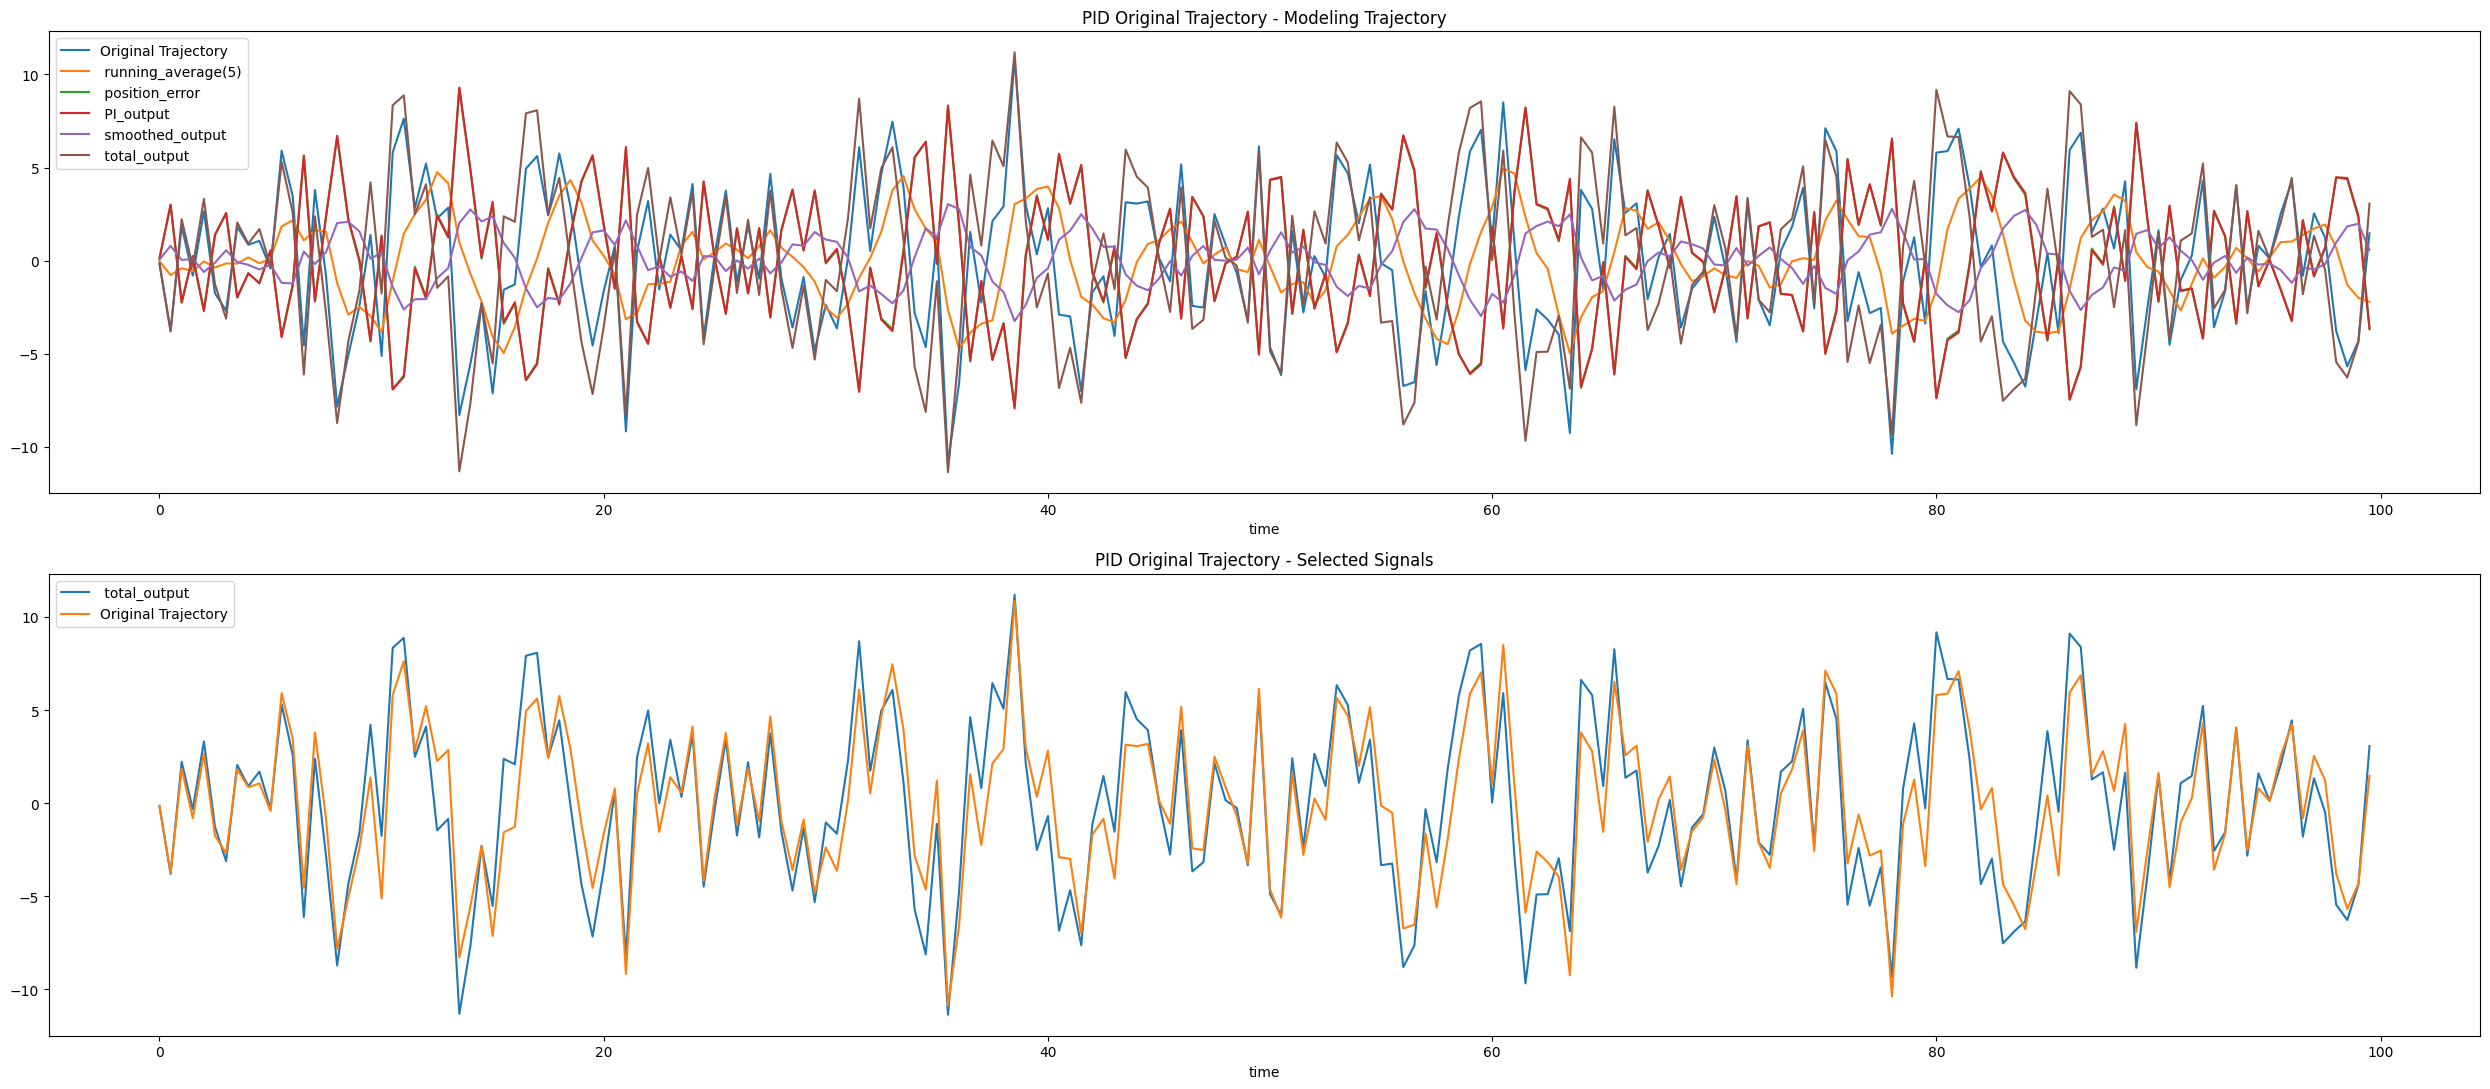

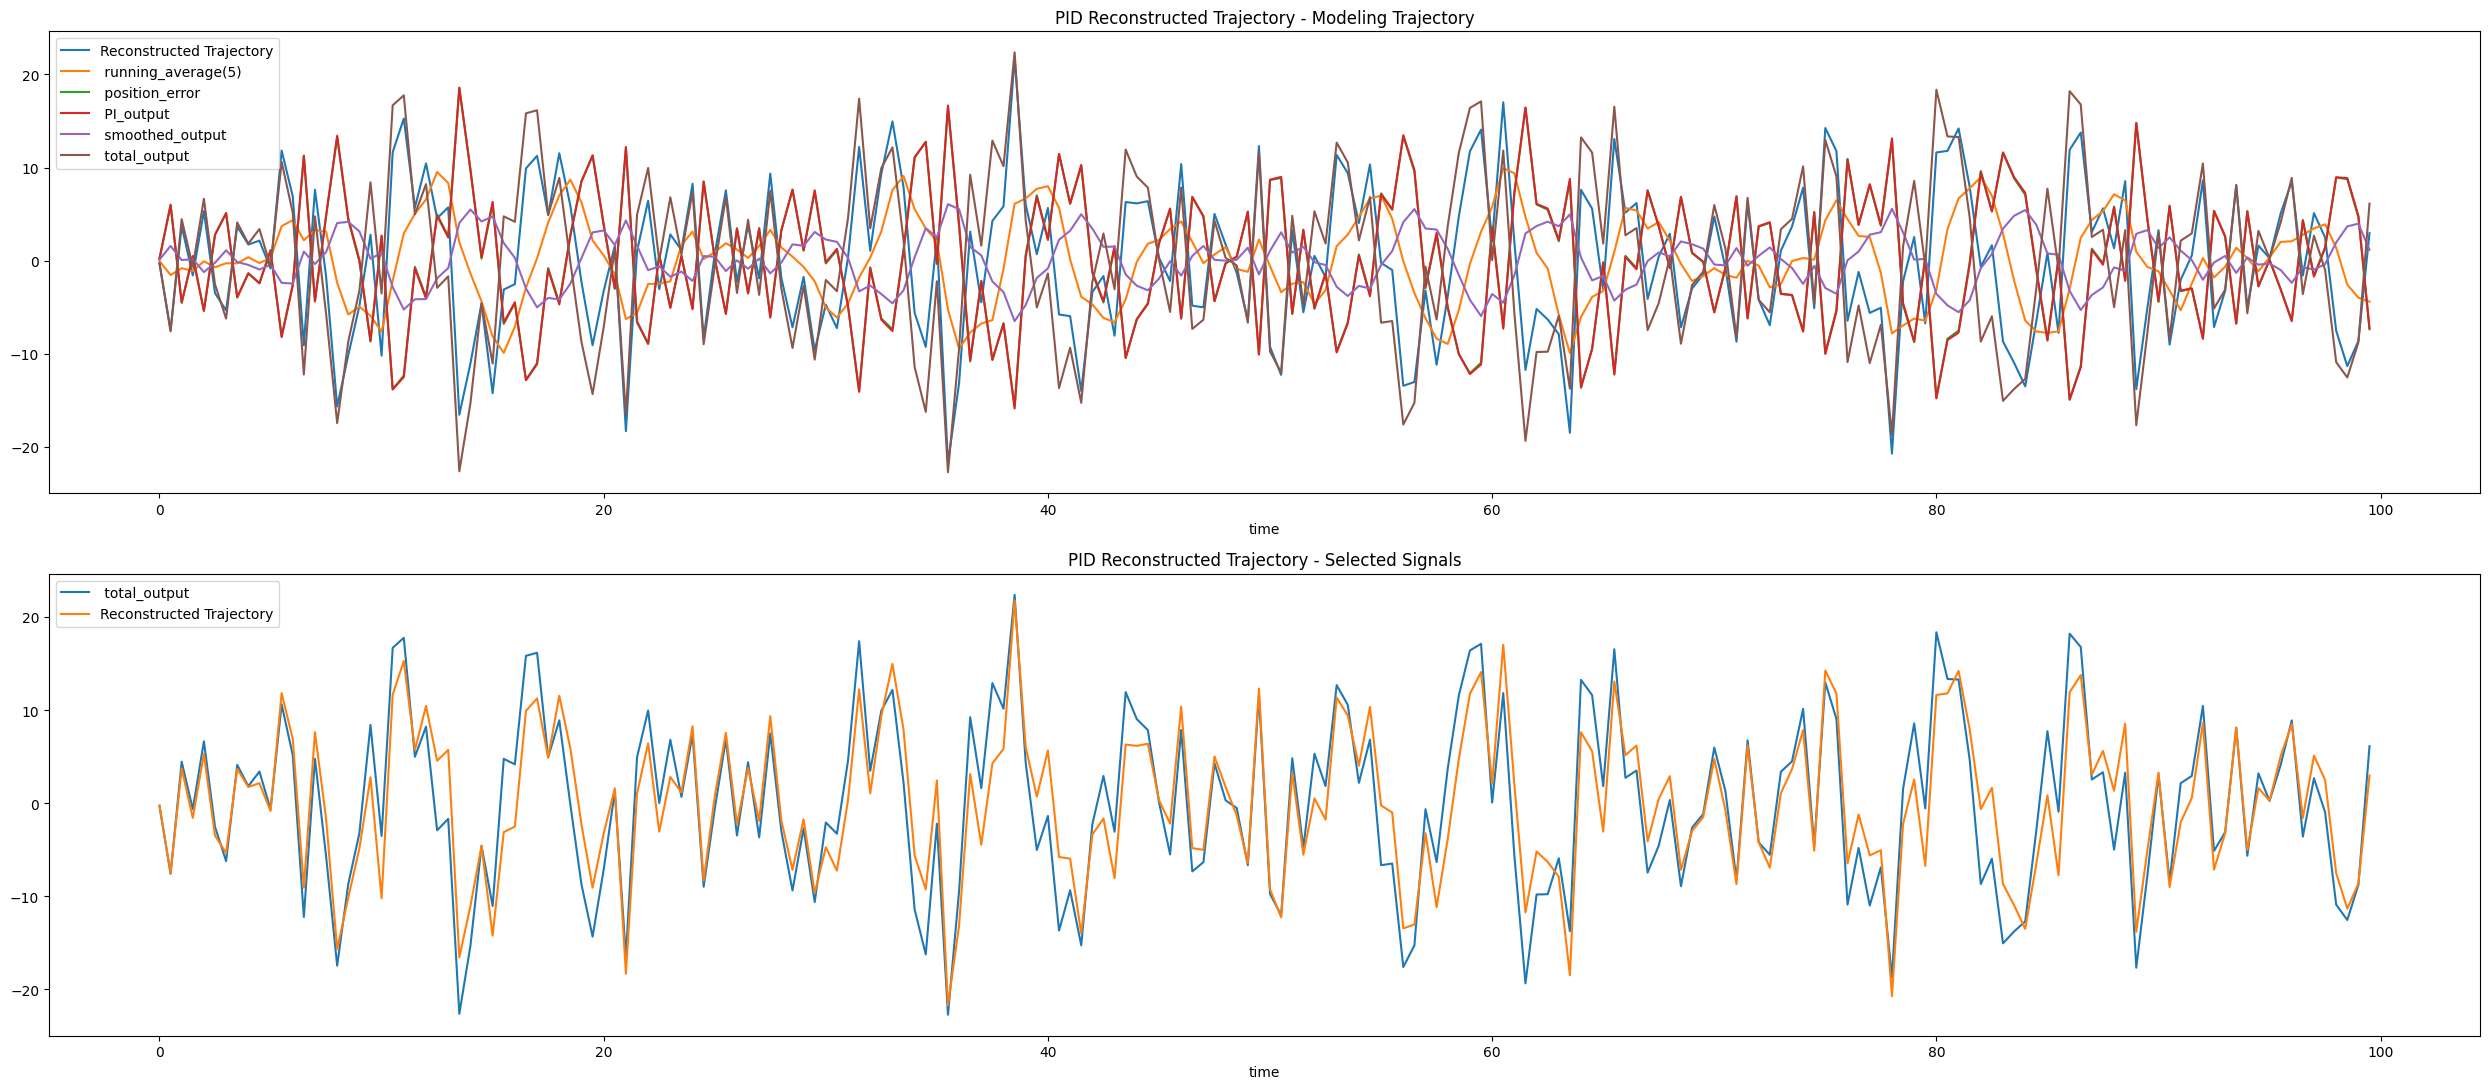

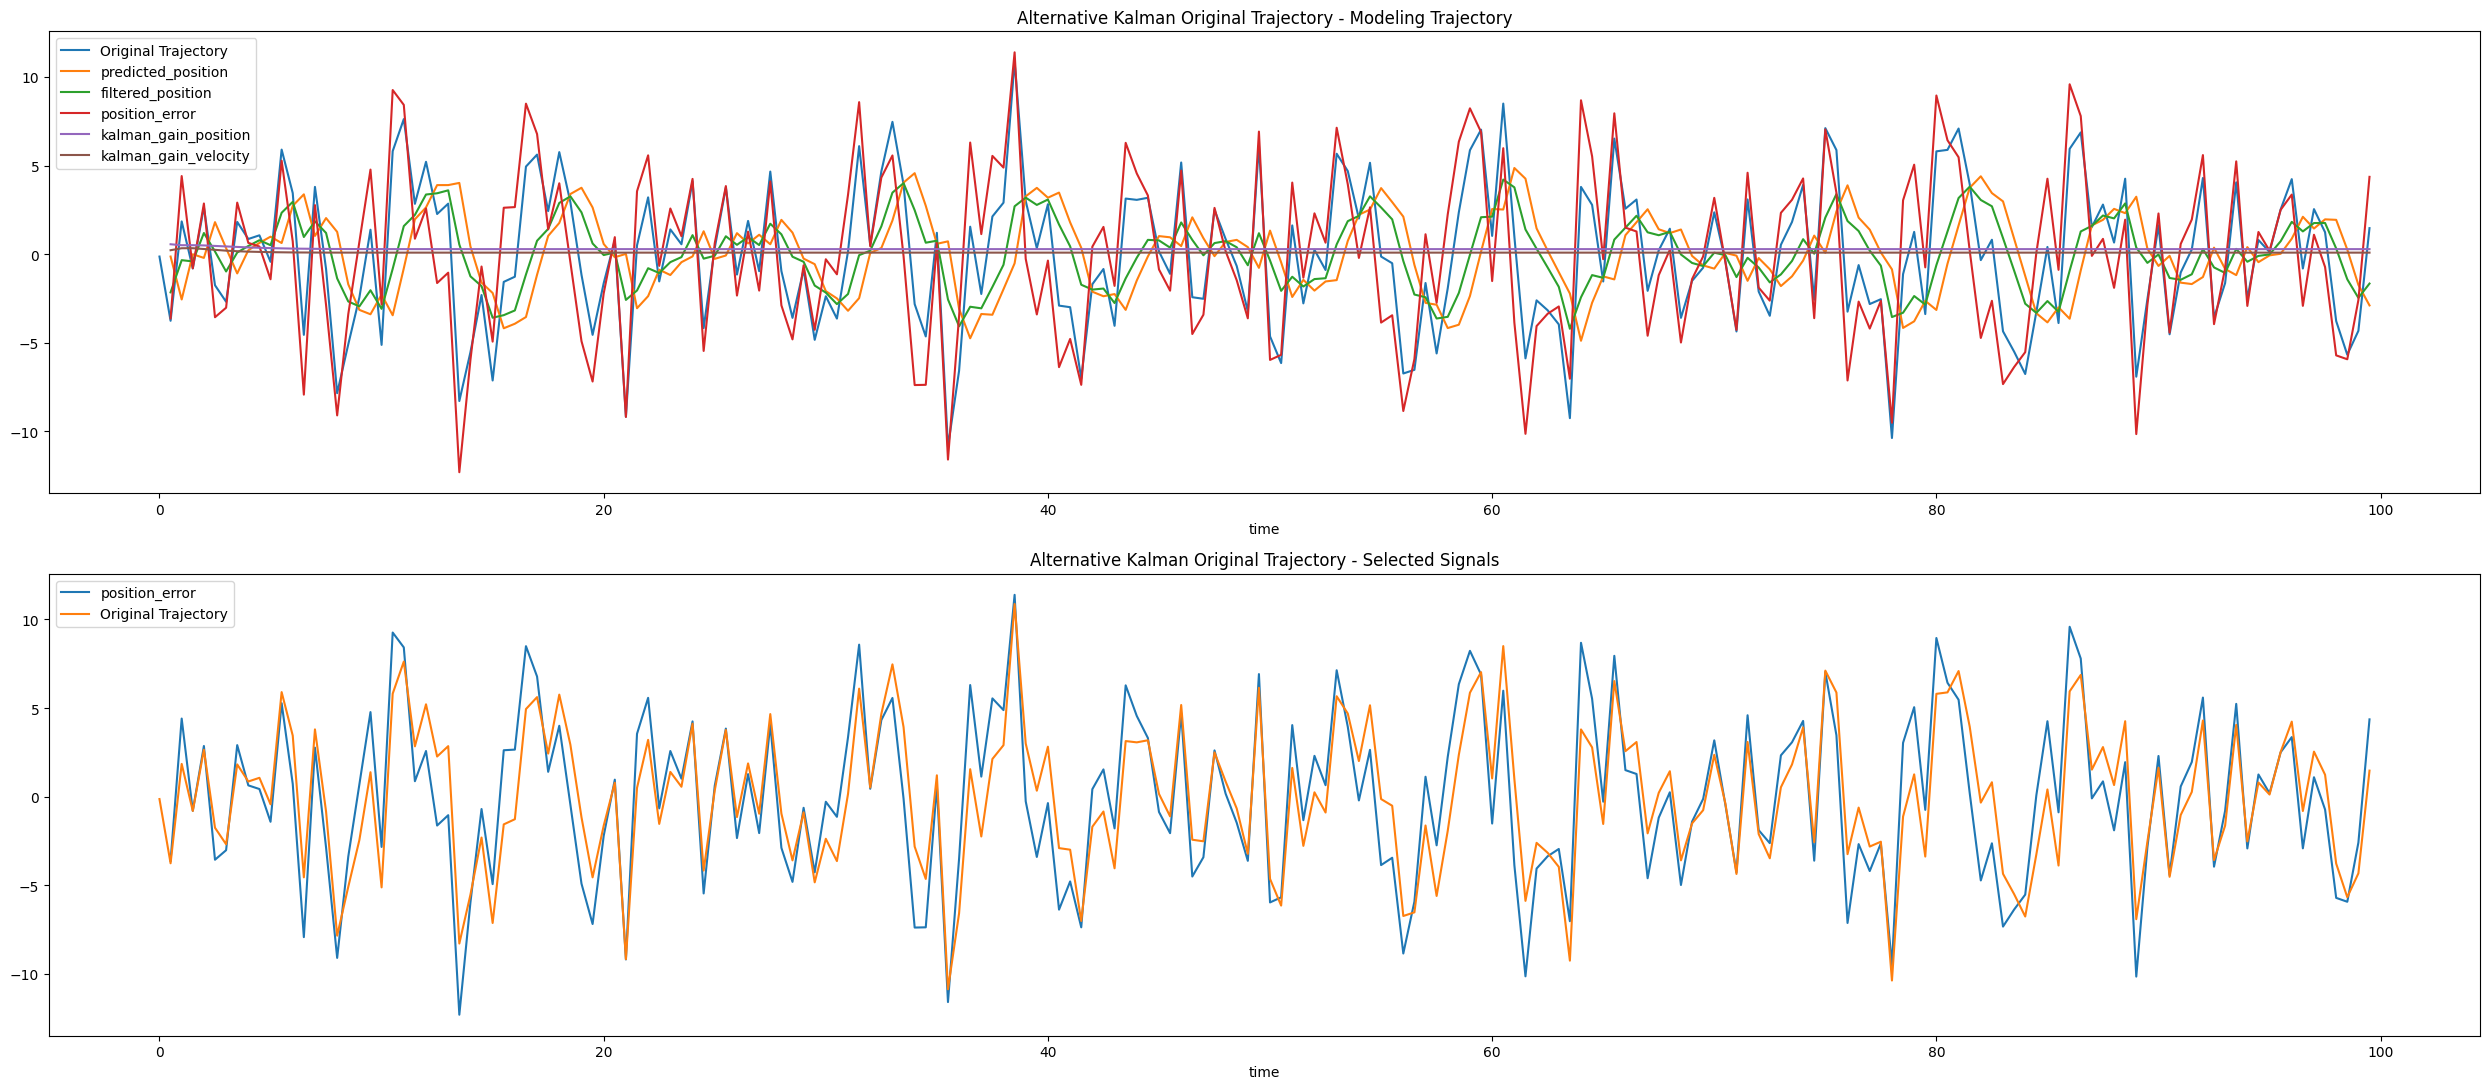

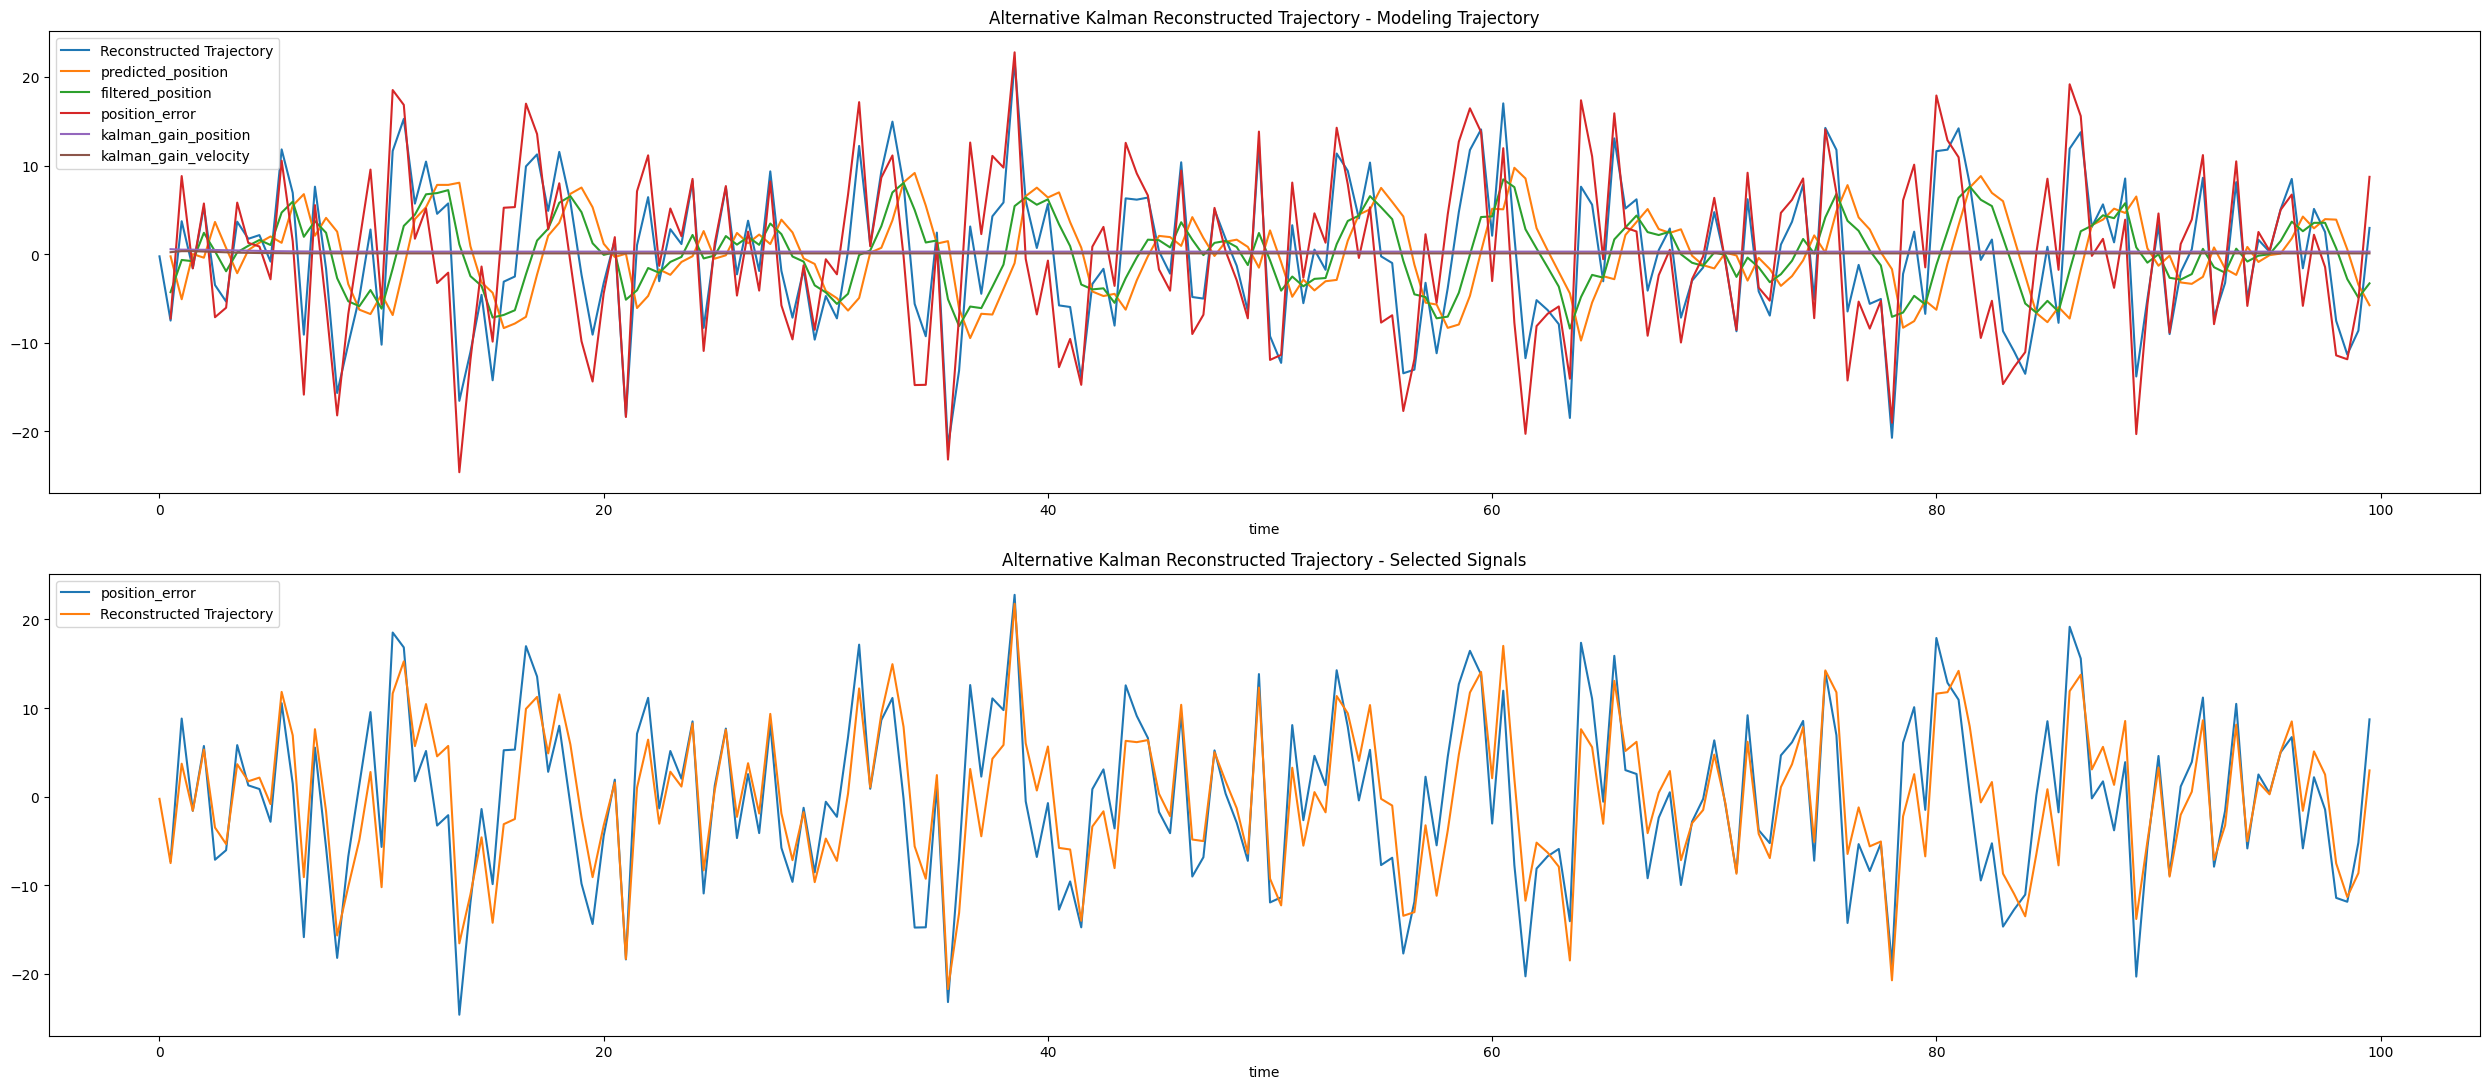

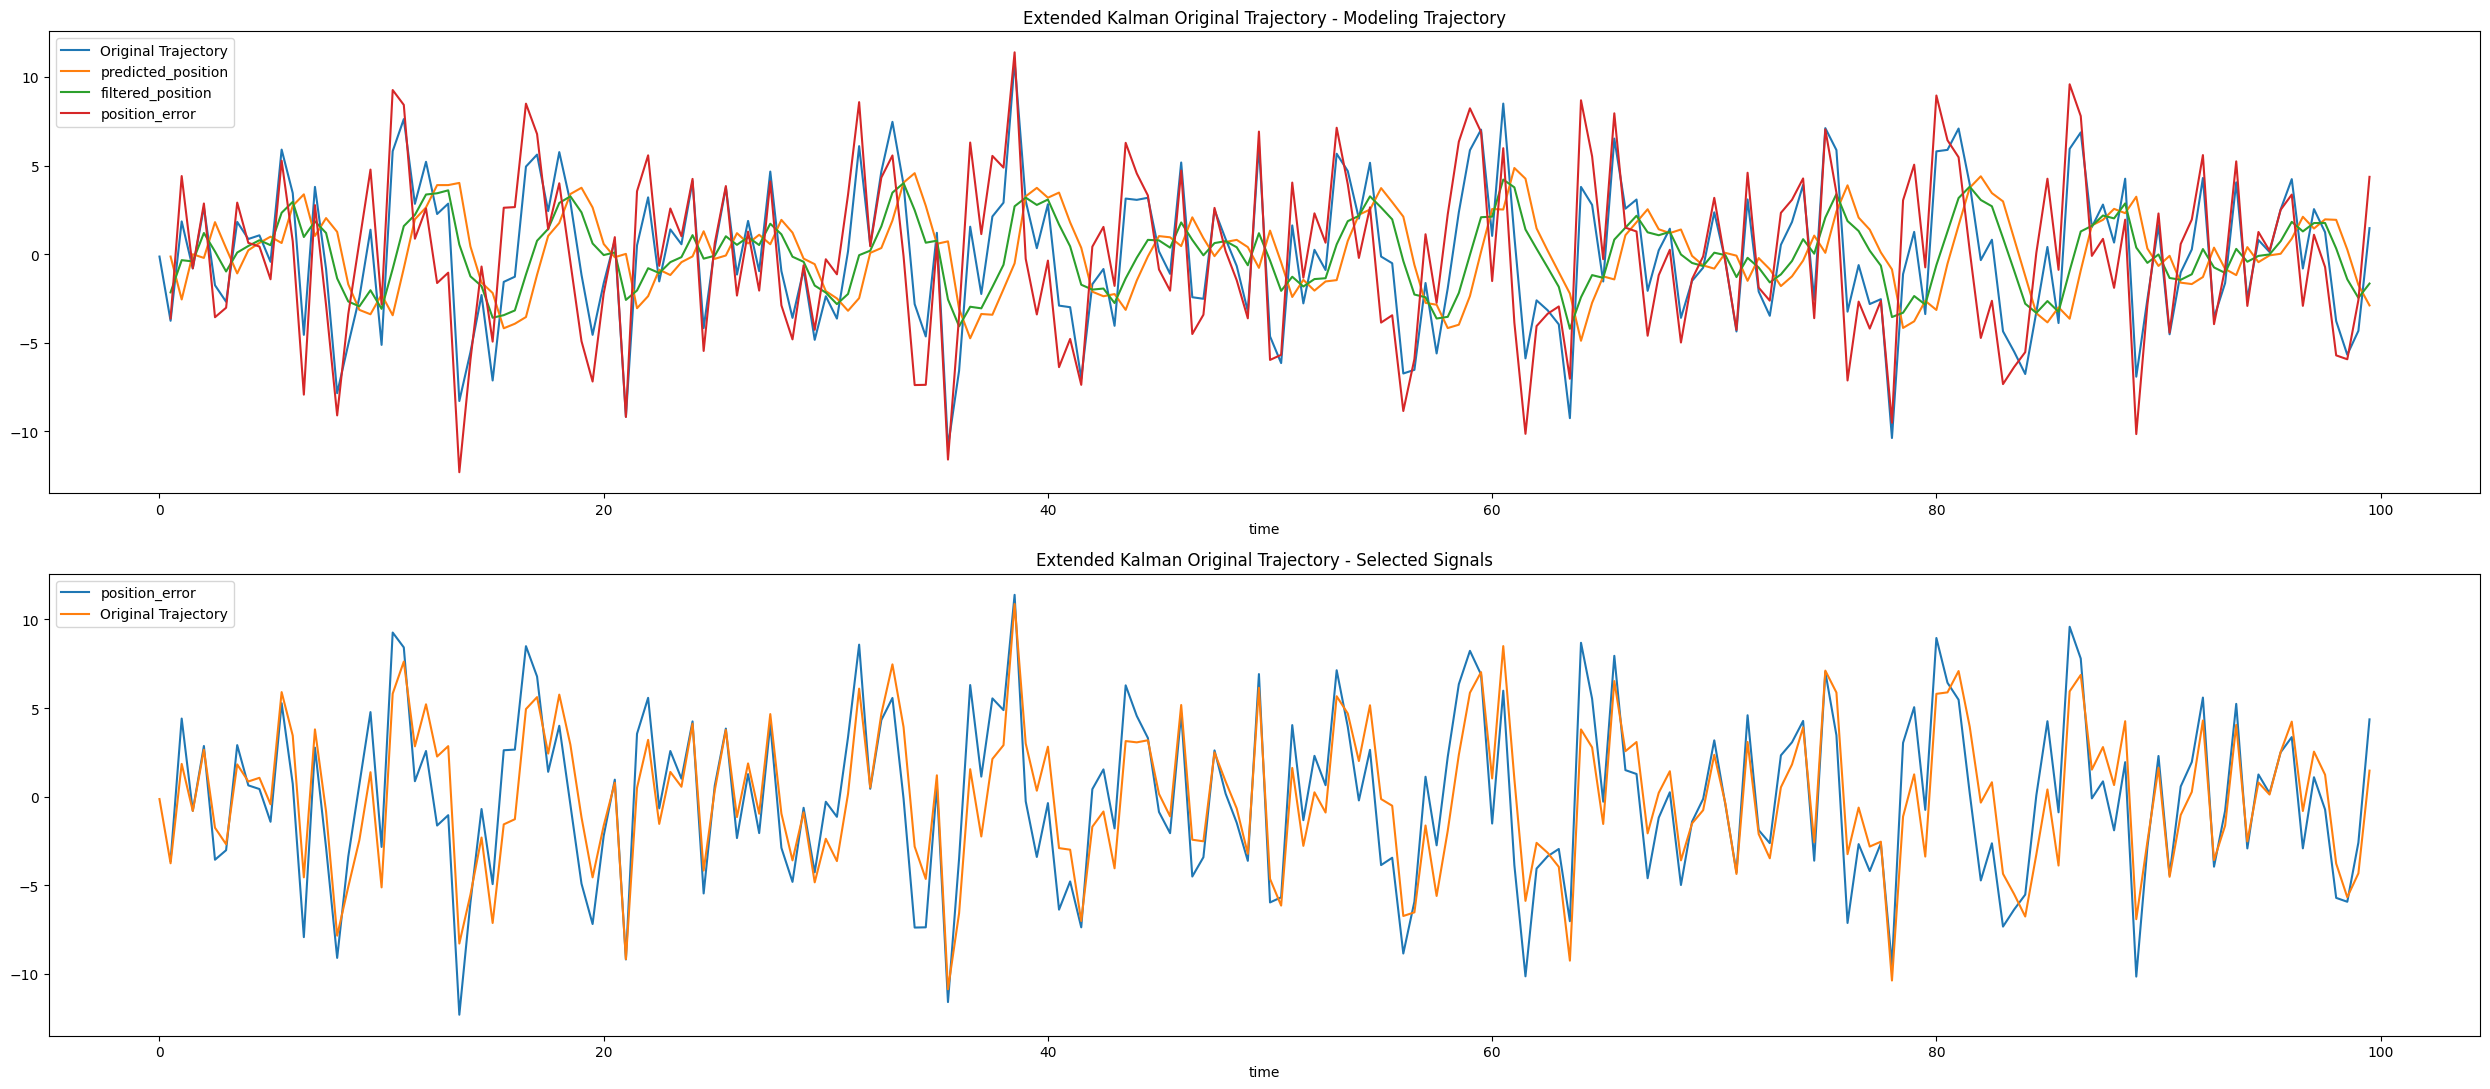

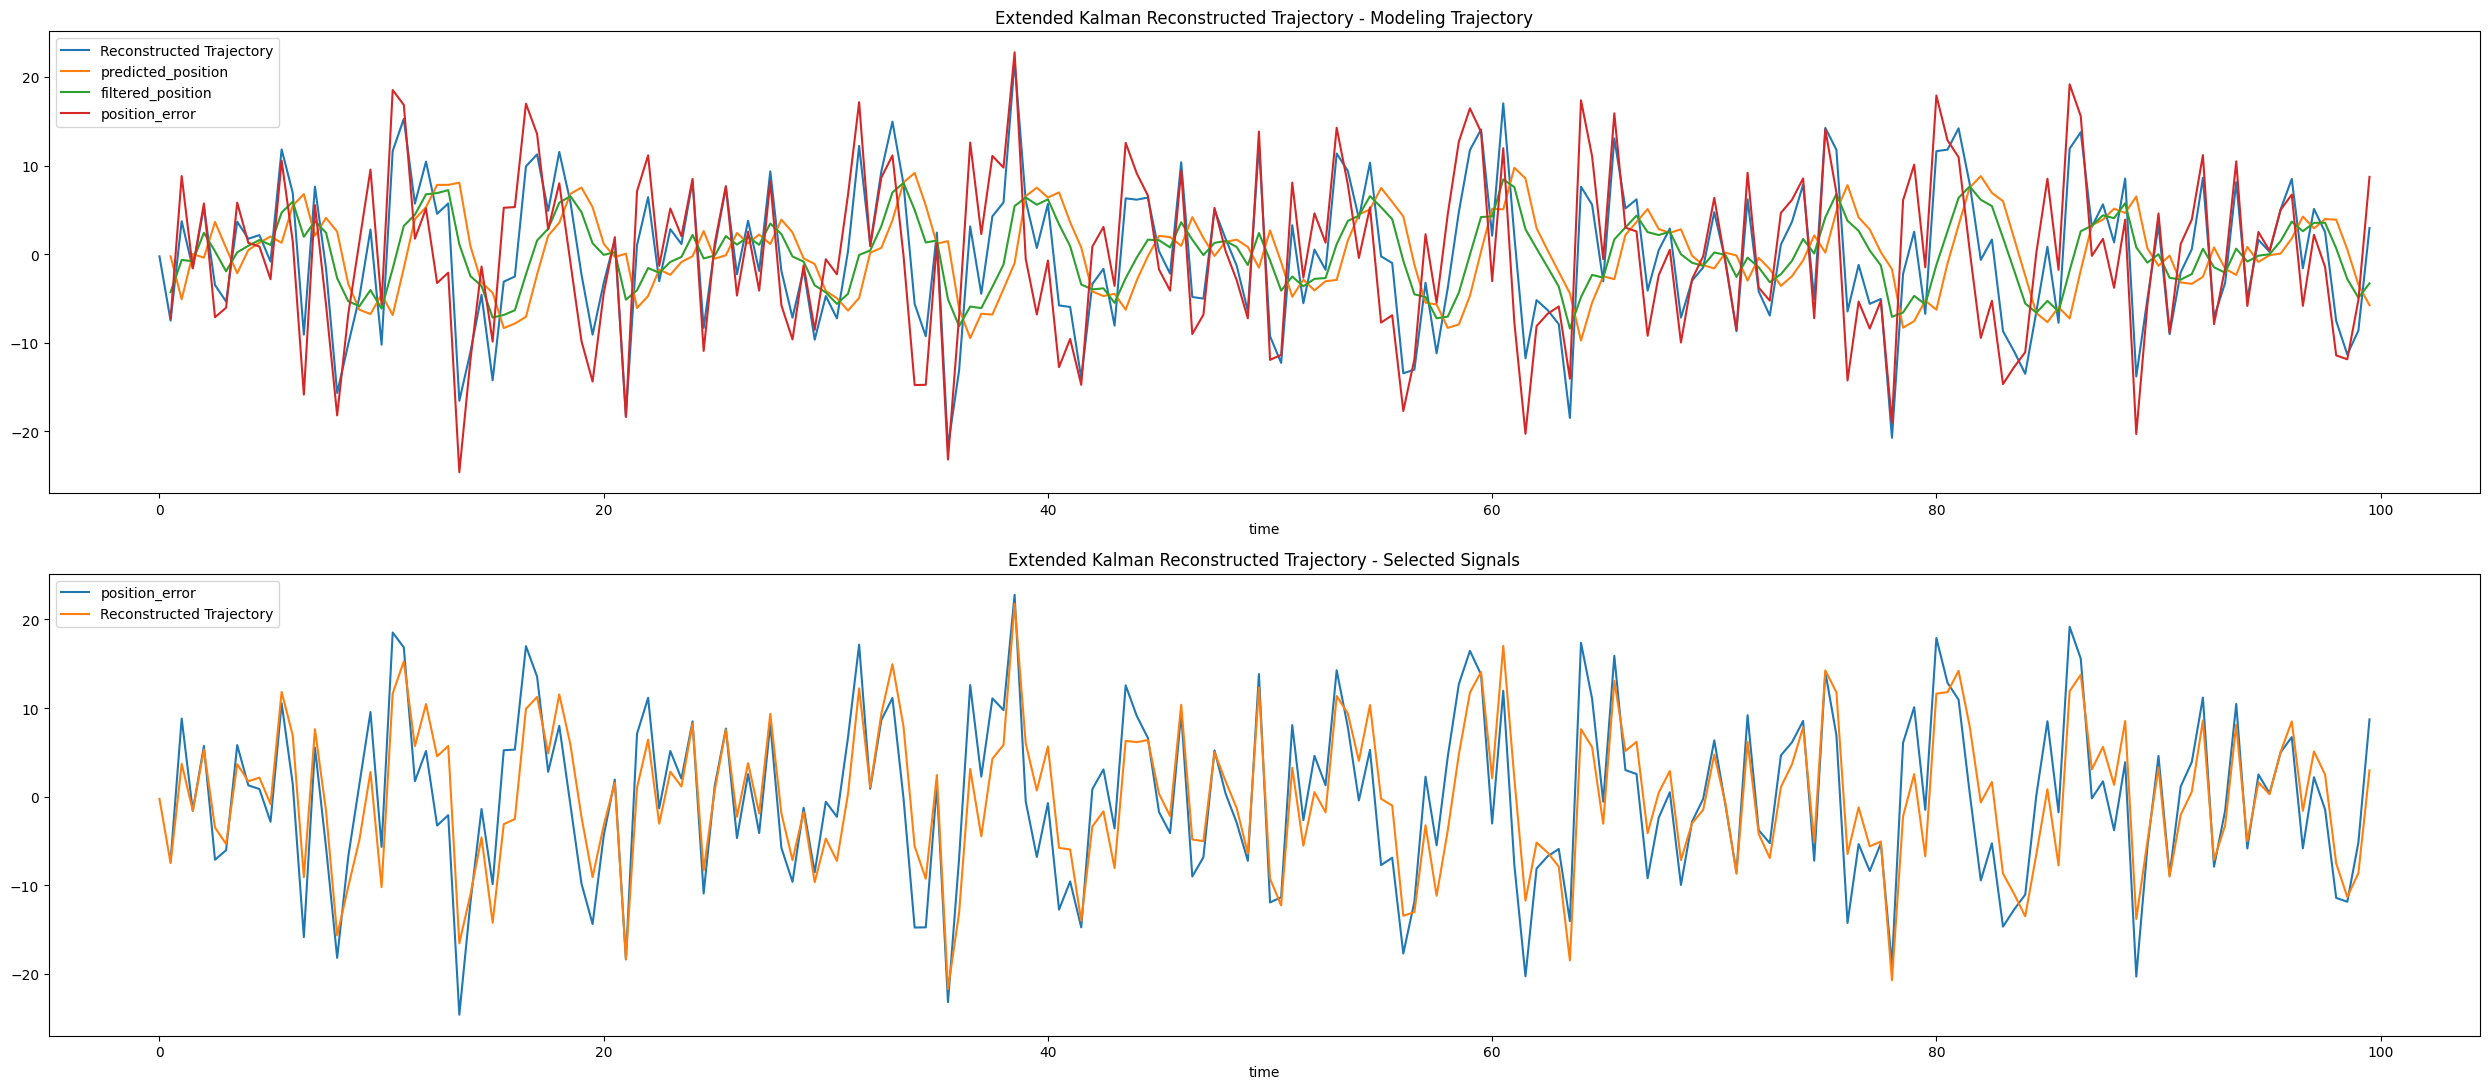

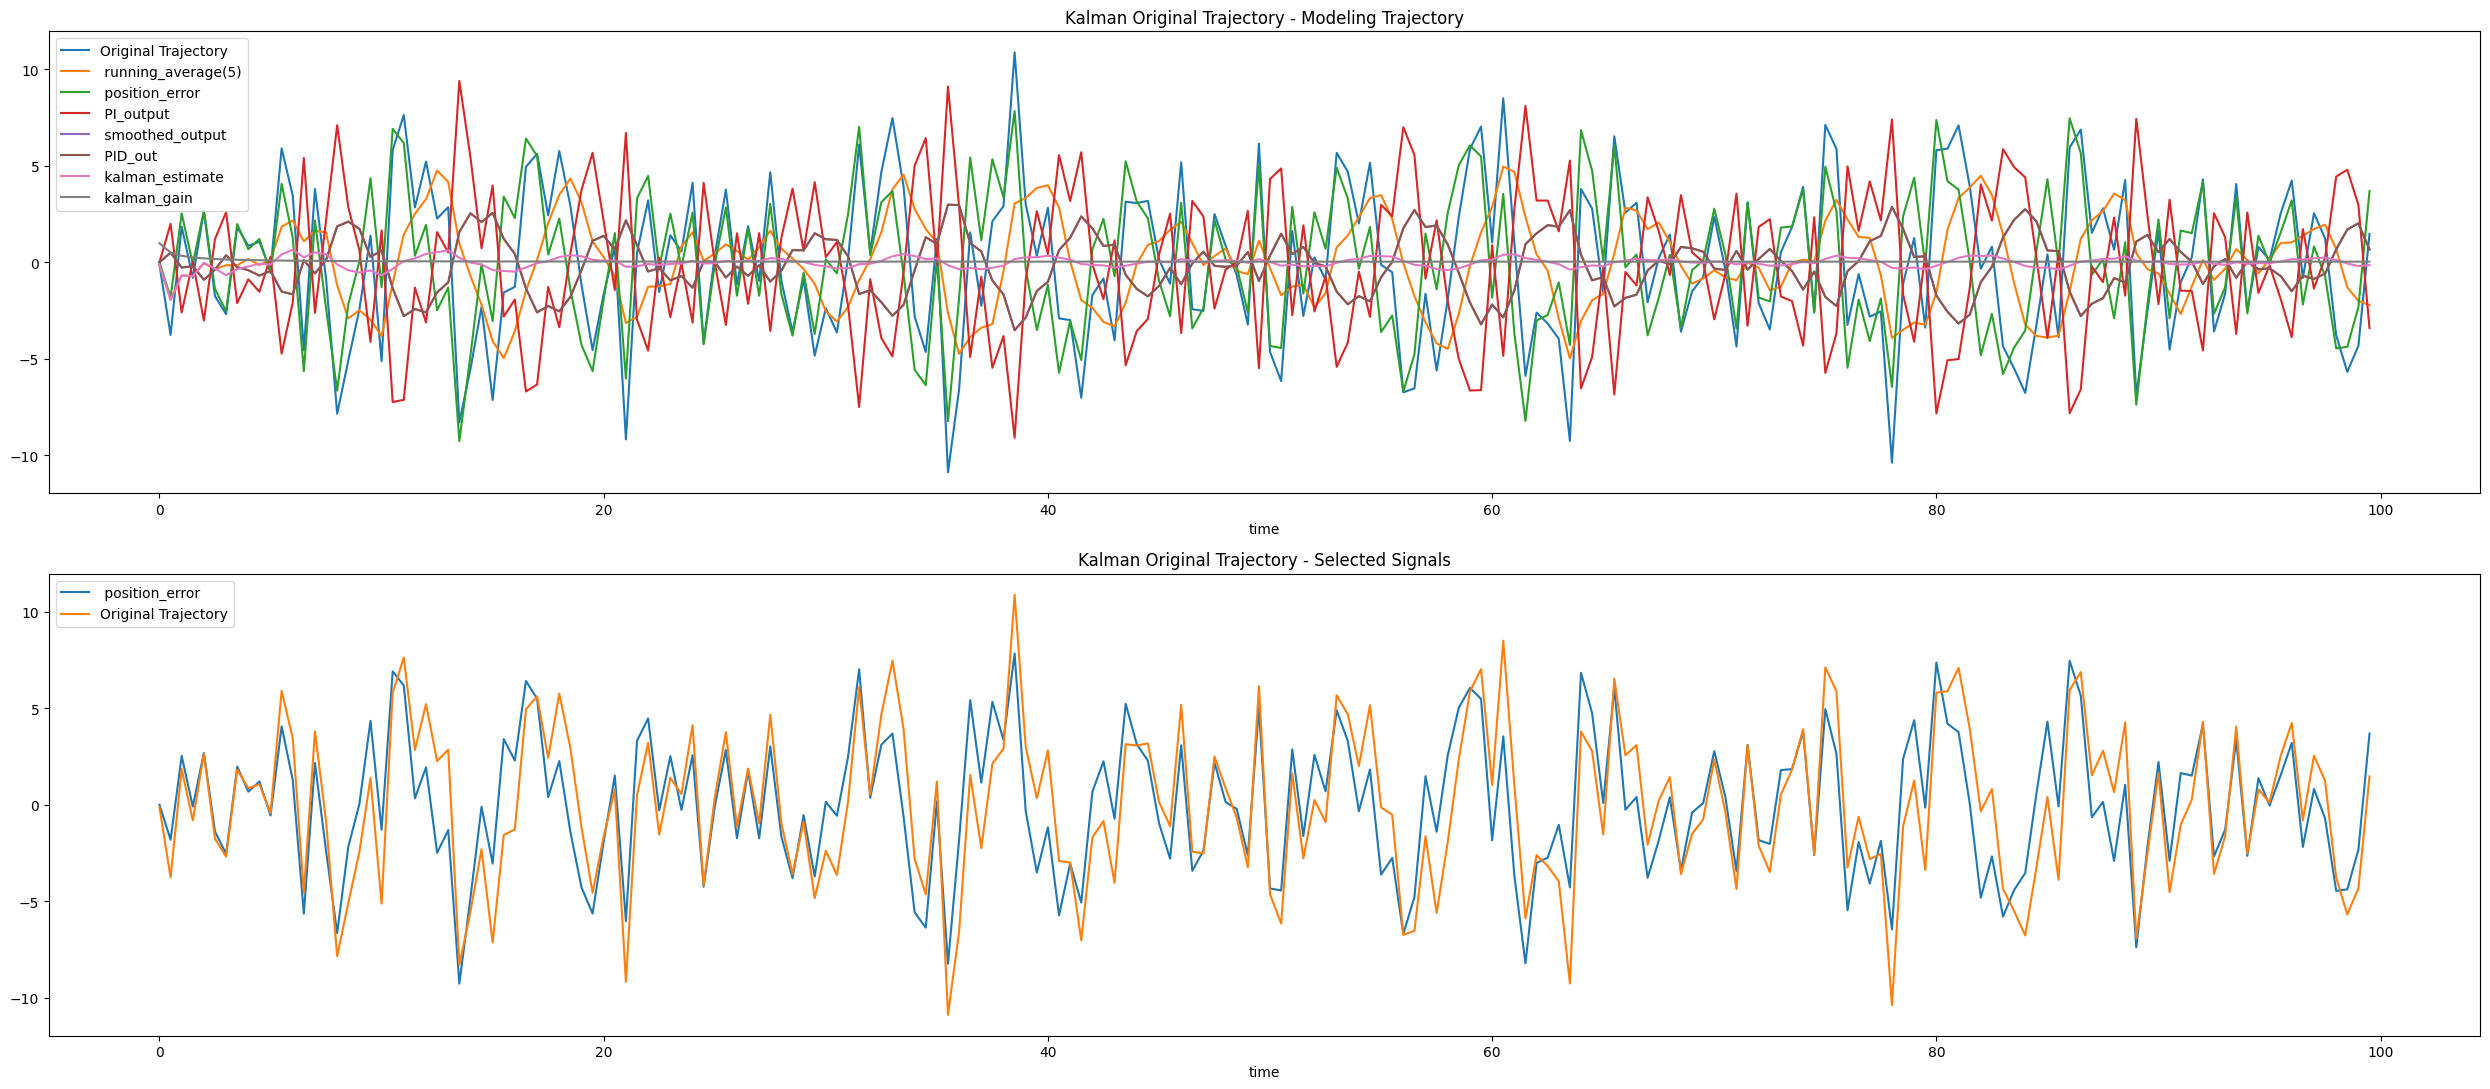

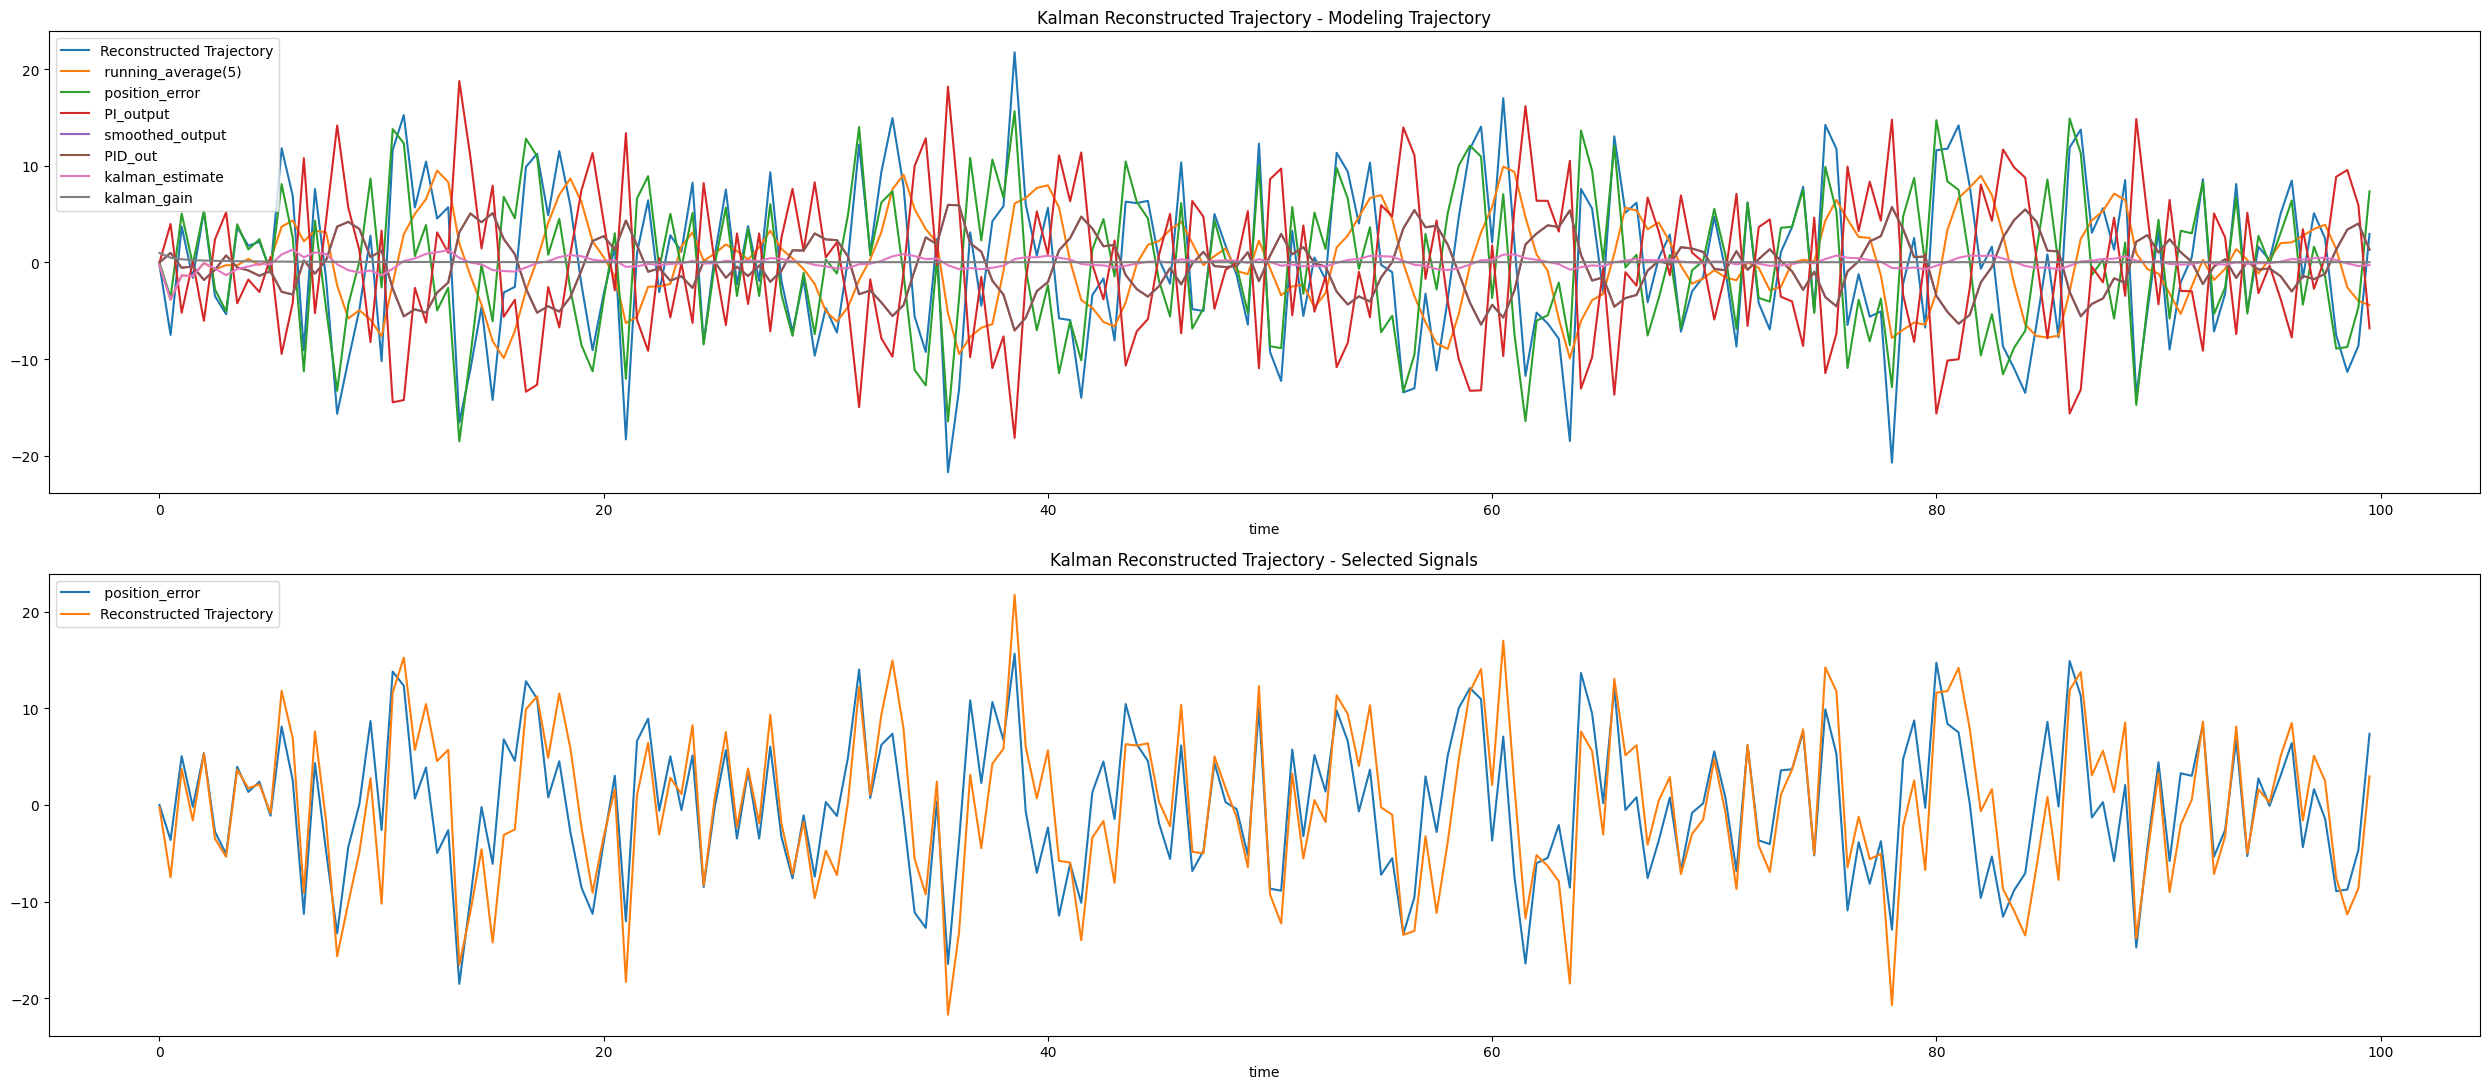

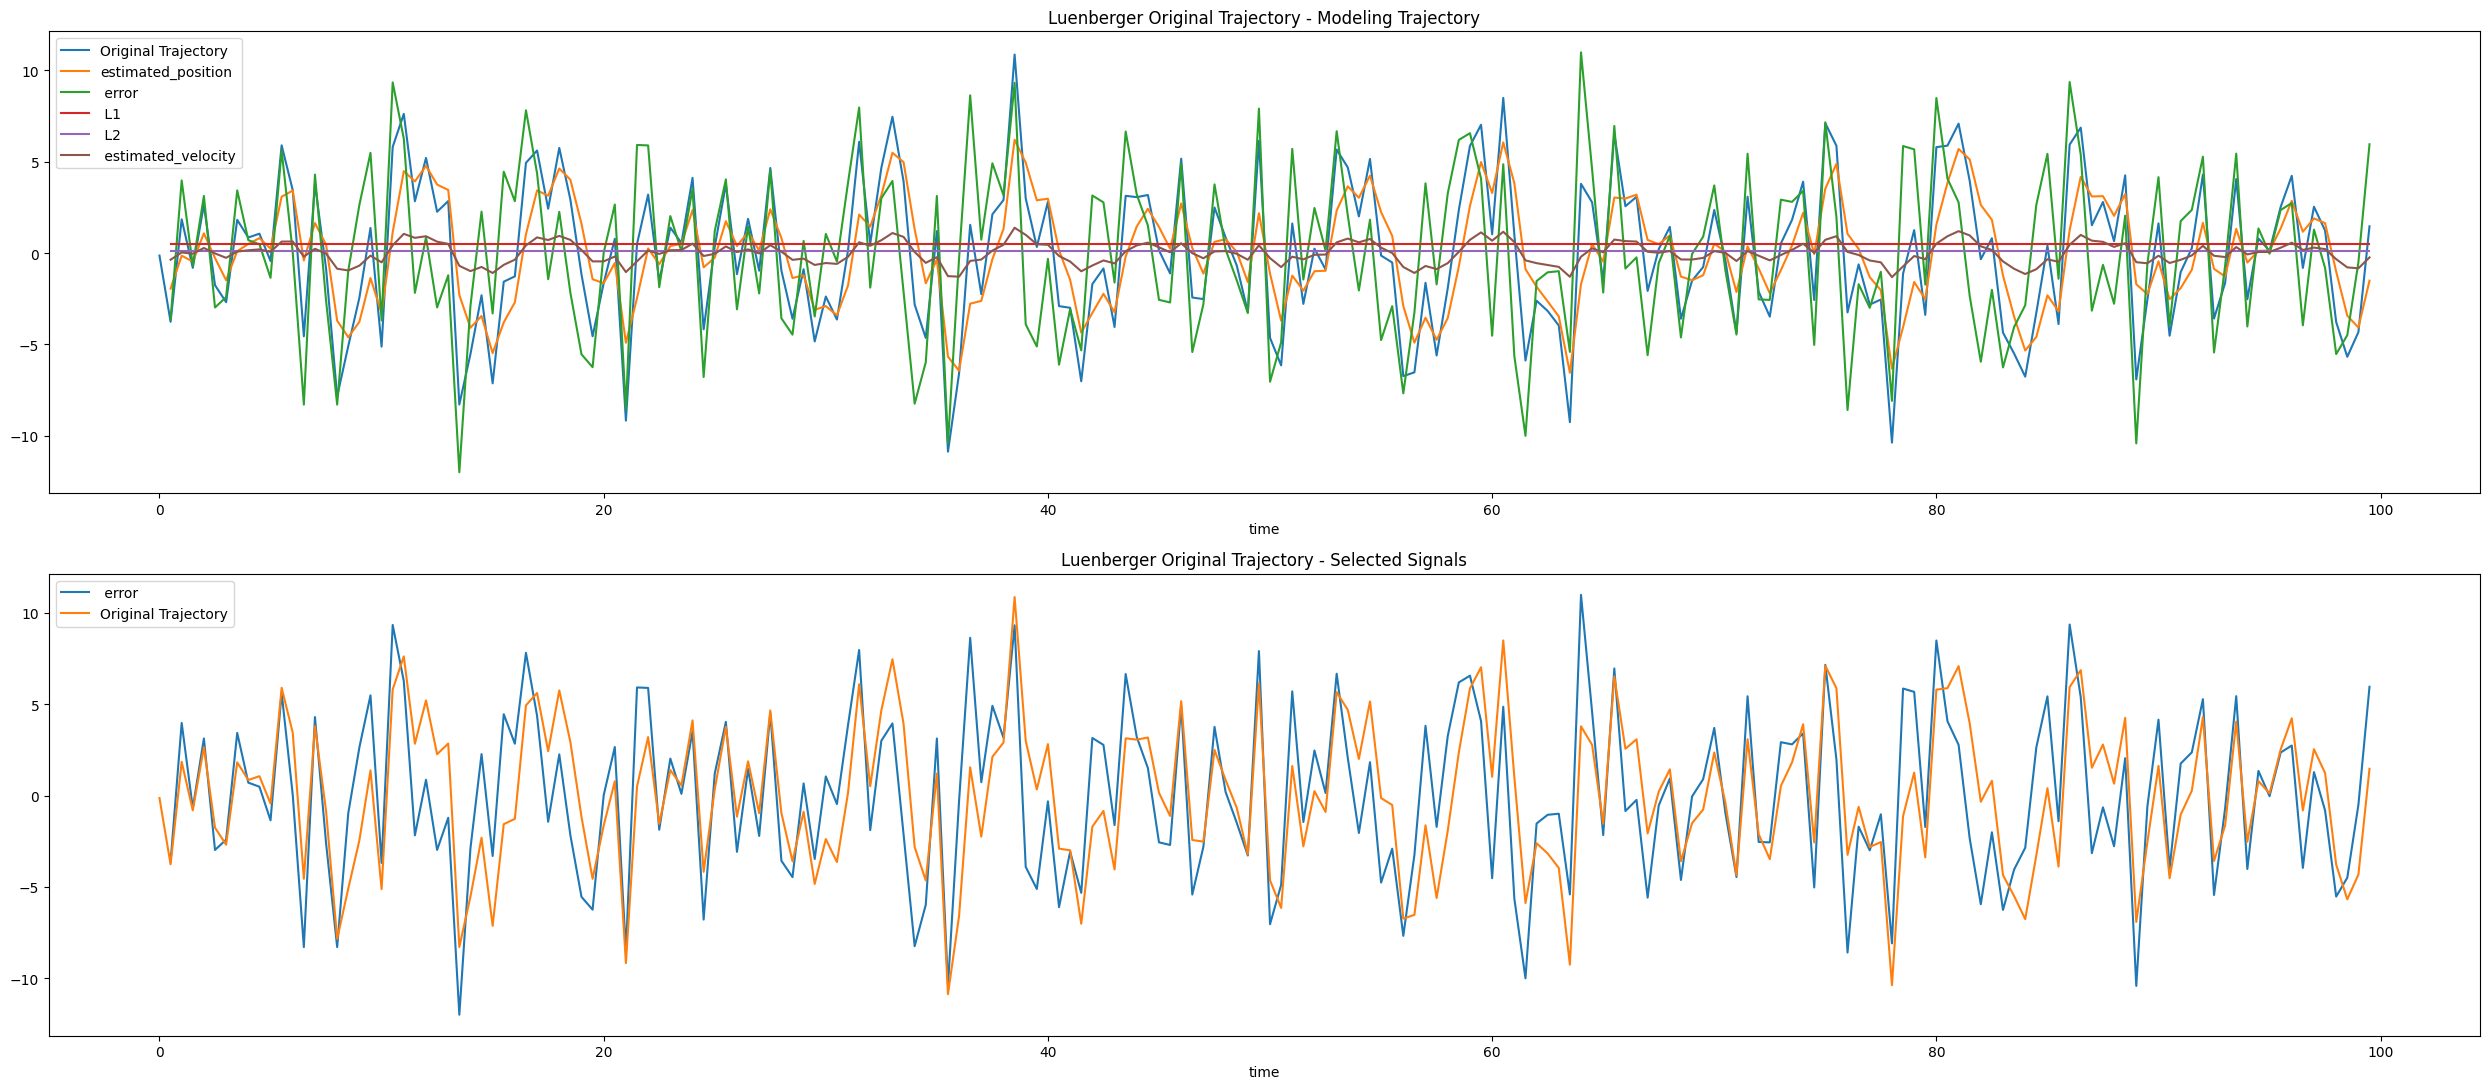

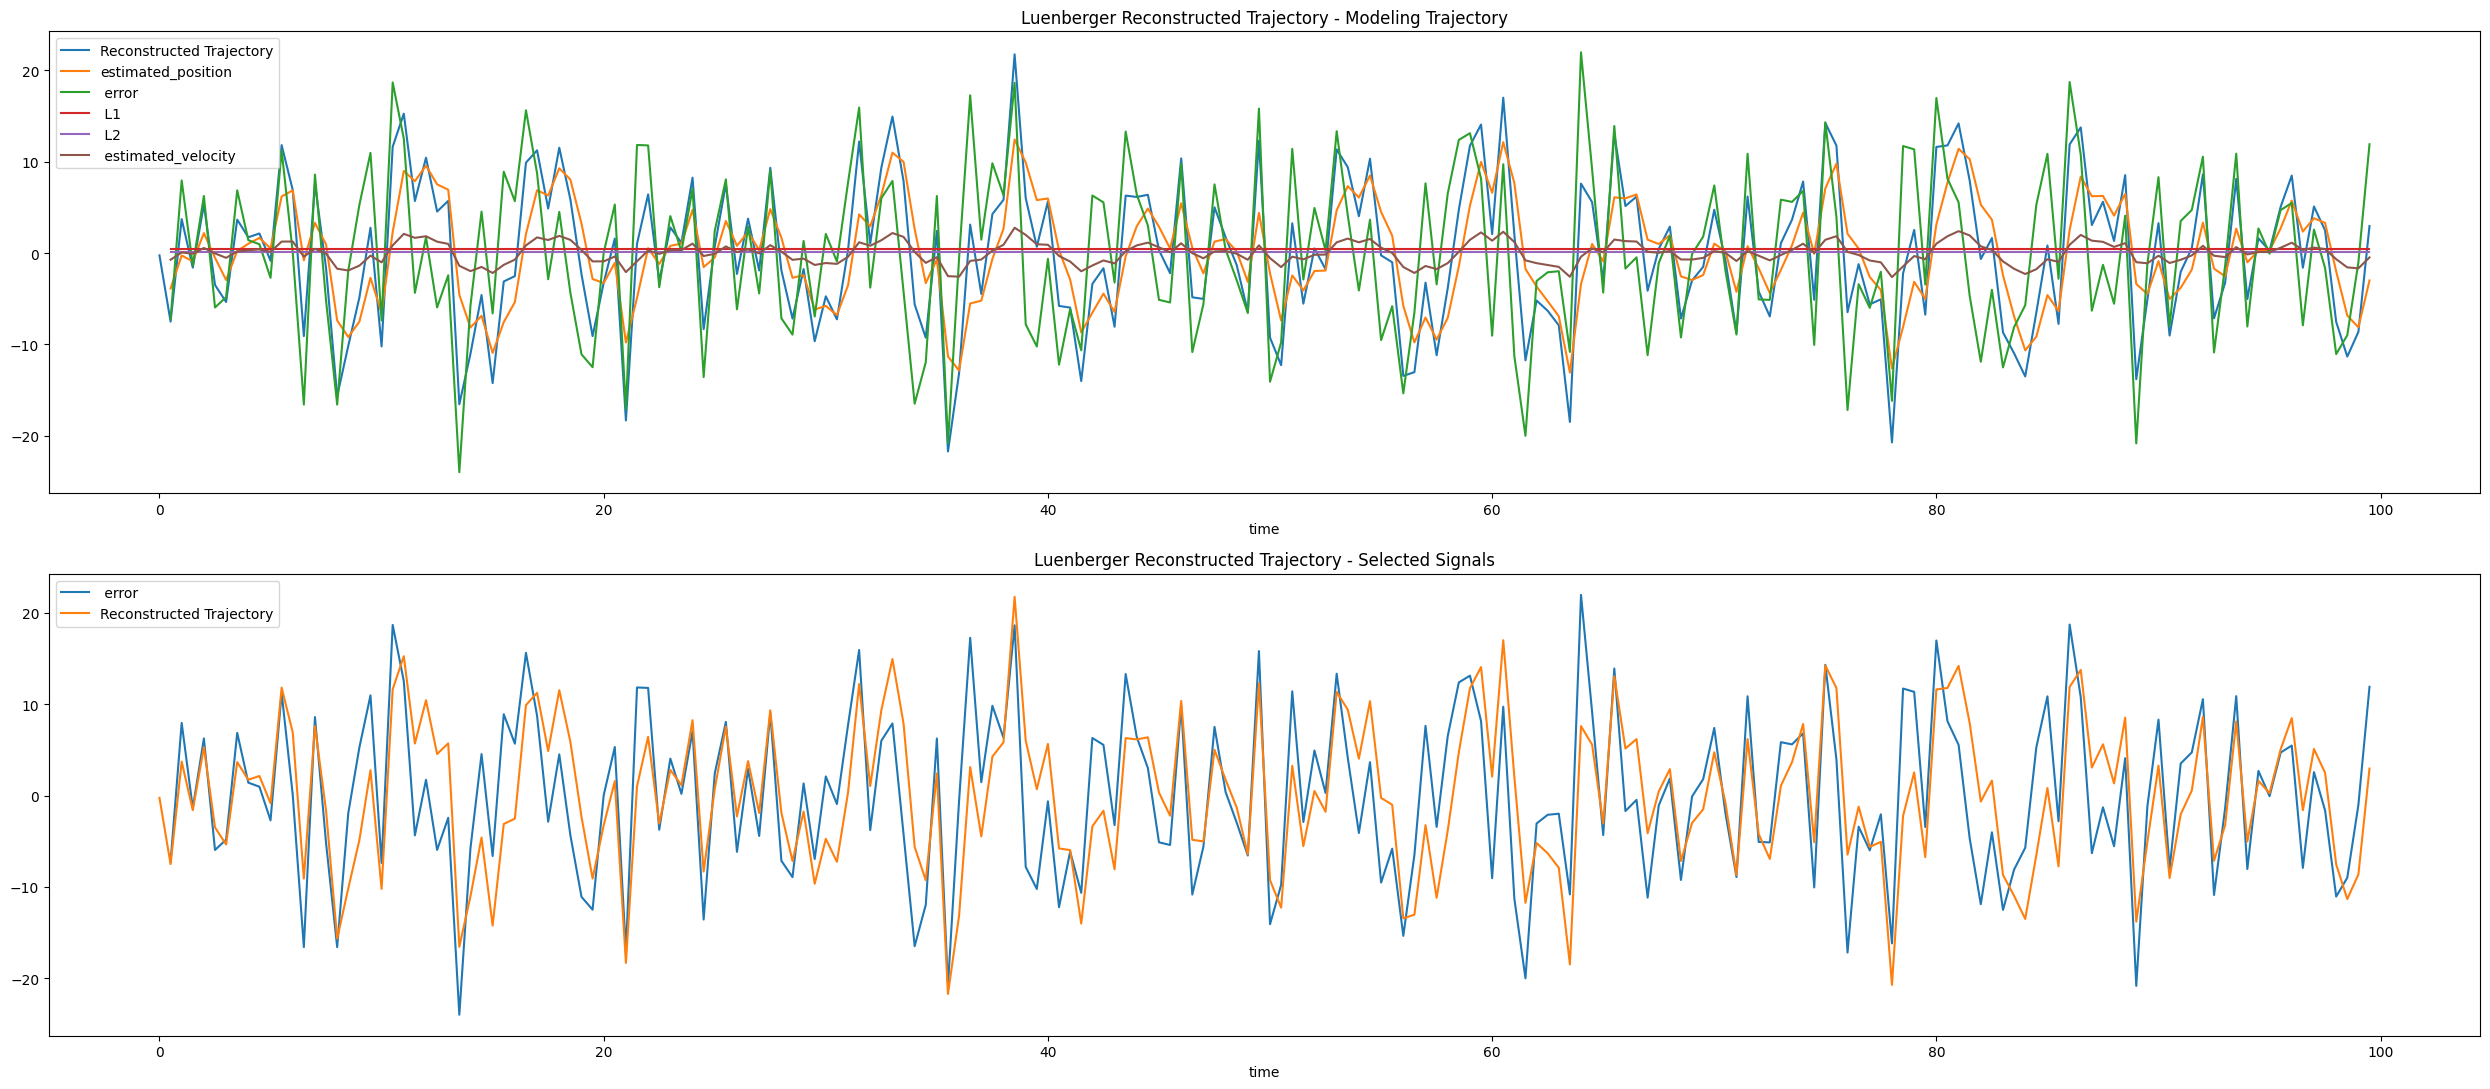

In [7]:
for file in sorted(csv_file):
    if file.endswith("_component.csv") or file.endswith("_position.csv"):
        continue

    df = pd.read_csv("fourier_data/" + file)
    headers = list(df.columns)[1:]

    has_measured = "measured_position" in headers
    if has_measured:
        headers.remove("measured_position")
    
    # Title formatting
    terms = file.split(".")[0].split("_")
    title = " ".join(terms)
    last_char = title[-1]
    title = title[:-1]
    if not (title == 'PID' or title == 'LQR'):
        title = title.title()

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(figsize=(25, 11), ncols=1, nrows=2)

    # Subplot 1: Full trajectory and model estimates
    if last_char == "1":
        ax1.plot(trajectory["time"], trajectory["position"], label="Original Trajectory")
        title += " Original Trajectory"
    elif last_char == "2":
        ax1.plot(inverted_trajectory["time"], inverted_trajectory["position"], label="Reconstructed Trajectory")
        title += " Reconstructed Trajectory"

    for header in headers:
        ax1.plot(df["time"], df[header], label=header)

    ax1.set_xlabel("time")
    ax1.set_title(title + " - Modeling Trajectory")
    ax1.legend(loc="upper left")

    # Subplot 2: Selected signal(s)
    selected_headers = []
    if "PID" in title:
        selected_headers = [col for col in df.columns if "total_output" in col]
    elif "Kalman" in title:
        selected_headers = [col for col in df.columns if "error" in col]
    elif "LQR" in title:
        selected_headers = [col for col in df.columns if any(k in col for k in ["estimated_position"])]
    elif "Luenberger" in title:
        selected_headers = [col for col in df.columns if any(k in col for k in ["error"])]

    for header in selected_headers:
        ax2.plot(df["time"], df[header], label=header)

    if last_char == "1":
        ax2.plot(trajectory["time"], trajectory["position"], label="Original Trajectory")
    elif last_char == "2":
        ax2.plot(inverted_trajectory["time"], inverted_trajectory["position"], label="Reconstructed Trajectory")

    ax2.set_xlabel("time")
    ax2.set_title(title + " - Selected Signals")
    ax2.legend(loc="upper left")

    # Layout and show
    plt.tight_layout()
    plt.show()
